# Statistical Learning - Group Work - Final Presentation

## Binary classification with Tensorflow 

### Group 16: Angelina Khatiwada & Rijin Baby

**18/06/2021**




In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow import keras
import numpy as np      
from sklearn.model_selection import train_test_split
import shutil
from sklearn.model_selection import StratifiedKFold
import keras
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from keras.callbacks import EarlyStopping

pd.get_option("display.max_columns", None)

20

In [2]:
#set up seed for reproducibility
seed = 5
np.random.seed(seed)

In [3]:
#loading cleaned dataset
coupon_data = pd.read_csv('https://raw.githubusercontent.com/rijinbaby/Statistical-Learning/main/cleaned_data_raw_columns.csv')
coupon_data.columns

Index(['destination', 'passanger', 'weather', 'temperature', 'time', 'coupon',
       'expiration', 'gender', 'age', 'maritalStatus', 'has_children',
       'education', 'occupation', 'income', 'Bar', 'CoffeeHouse', 'CarryAway',
       'RestaurantLessThan20', 'Restaurant20To50', 'toCoupon_GEQ15min',
       'toCoupon_GEQ25min', 'direction_same', 'direction_opp', 'Y',
       'age_weightage', 'income_weightage', 'occupation_class',
       'expiration_weightage'],
      dtype='object')

In [4]:
#dropping and transforming columns
coupon_data = coupon_data.drop(columns = ['expiration', 'occupation', 'time', 'direction_opp','age_weightage', 'income_weightage' ])

coupon_data['temperature'] = coupon_data['temperature'].astype(str)

scaler = StandardScaler(with_mean=False)
coupon_data['expiration_weightage'] = scaler.fit_transform(coupon_data['expiration_weightage'].values.reshape(-1,1))

coupon_data.shape

(12684, 22)

In [5]:
#creating dummy variables
coupon_data = pd.get_dummies(coupon_data, drop_first = True)
print(coupon_data.shape)

(12684, 71)


In [6]:
#creating X and Y

X_data = coupon_data.drop('Y', axis =1).to_numpy()
print(X_data.shape)
Y_data = coupon_data['Y'].to_numpy()
print(Y_data.shape)

(12684, 70)
(12684,)


### PCA analysis

In [7]:
#PCA check with 20 components
pca = PCA(n_components=20)
pca.fit(X_data)

PCA(n_components=20)

[0.10184582 0.06065888 0.05325733 0.04386009 0.04312251 0.03708566
 0.03214623 0.03017509 0.02808943 0.02767012 0.02665966 0.02562316
 0.02328581 0.02187417 0.02146314 0.02039089 0.02012885 0.01971353
 0.01886316 0.01737235]


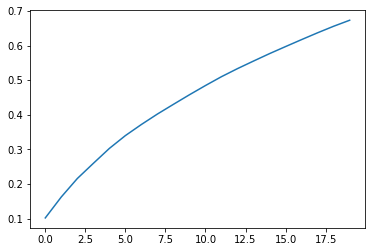

In [8]:
print(pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [9]:
# project from 70 to 2 dimensions
pca = PCA(2)  
projected = pca.fit_transform(X_data)
print(X_data.shape)
print(projected.shape)

(12684, 70)
(12684, 2)


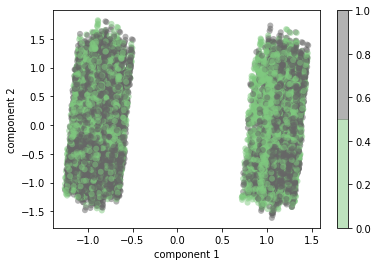

In [10]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=Y_data, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Accent', 2))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

## Basic Neural network using Keras

In [11]:
#splitting dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.25, random_state= 0)

# Check the dimension of the sets
print('X_train:',np.shape(X_train))
print('y_train:',np.shape(y_train))
print('X_test:',np.shape(X_test))
print('y_test:',np.shape(y_test))

X_train: (9513, 70)
y_train: (9513,)
X_test: (3171, 70)
y_test: (3171,)


### Network parameters:
   1. **ADAM** as gradient descent optimization algorithm
   2. Activation function:
- output layer : **sigmoid/ hard_sigmoid** - binary classification
- hidden layers: relu or tahn
   3. Metrics: **accuracy** as the data is balanced
   4. Loss function:**binary cross entropy** -- binary classification
   5. Hyperparameters (can be tuned)
- number of epochs - number times that the learning algorithm will work through the entire training dataset 
- batch_size - number of training examples utilized in one iteration 
   6. Number of layers: 2-3 (empirically)
   7. Number of neurons on each layer (empirically) 
   8. Regularization parameters/ Cross-Validation or Early Stopping to reduce overfitting:
- Validation split 0.2
- CV with 5 folds
     
**Adding more layers to NN** can help addressing bias, not variance.

**Regularizaition** is used to reduce variance. By adding a regularizer, you may enforce the training process to steer towards relatively “simple” weights, which may make your model more generic and thus scalable.

**Activation Functions**:
Sigmoid or Logistic Activation Function: Sigmoid function maps any input to an output ranging from 0 to 1. For small values (<-5), sigmoid returns a value close to zero, and for large values (>5) the result of the function gets close to 1.

**Loss Functions**:
For Binary Classification tasks - BinaryCrossentropy. Computes the cross-entropy loss between true labels and predicted labels. We use this cross-entropy loss when there are only two label classes (assumed to be 0 and 1).

In [12]:
#defining a NN model
def create_model():
    model = tf.keras.Sequential([
          tf.keras.layers.InputLayer(input_shape = (70)),
          tf.keras.layers.Dense(64, activation = "relu", kernel_initializer='normal'),
          tf.keras.layers.Dense(32, activation = "sigmoid", kernel_initializer='normal'),
          tf.keras.layers.Dense(1, activation='hard_sigmoid', kernel_initializer='normal')
      ])

    model.compile(optimizer = "adam", loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [13]:
#define early_stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1)

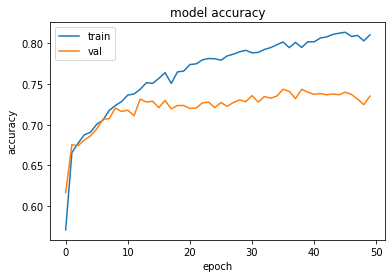

In [14]:
#set up seed for reproducibility
seed = 5
np.random.seed(seed)

model = create_model()
history = model.fit(X_train, y_train, validation_split = 0.2, epochs=50, batch_size=64, verbose =0)
#callbacks=[es]

# plot training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
#running cross validation over a train set
estimator = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=50, batch_size=64, validation_split = 0.2, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print(" Training Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

 Training Accuracy: 73.07% (1.22%)


In [16]:
# predicting accuracy
# Stochastic nature of the algorithms, run multiple time to see the average test accuracy
# setting seed does not help
n = 0
acc_scores = []
while n < 10:
    print(n)
    model = create_model()
    history = model.fit(X_train, y_train, validation_split = 0.2, epochs=50, batch_size=64, verbose =0)
    loss_and_metrics = model.evaluate(X_test, y_test)
    acc_scores.append(loss_and_metrics[1])
    n +=1

0
100/100 [==============================] - 0s 1ms/step - loss: 0.8709 - accuracy: 0.7203
1
100/100 [==============================] - 0s 1ms/step - loss: 0.9841 - accuracy: 0.7253
2
100/100 [==============================] - 0s 1ms/step - loss: 0.7396 - accuracy: 0.7263
3
100/100 [==============================] - 0s 1ms/step - loss: 0.9195 - accuracy: 0.7253
4
100/100 [==============================] - 0s 1ms/step - loss: 0.6970 - accuracy: 0.7278
5
100/100 [==============================] - 0s 1ms/step - loss: 0.7966 - accuracy: 0.7297
6
100/100 [==============================] - 0s 2ms/step - loss: 0.8805 - accuracy: 0.7048
7
100/100 [==============================] - 0s 2ms/step - loss: 0.9076 - accuracy: 0.7178
8
100/100 [==============================] - 0s 1ms/step - loss: 0.7949 - accuracy: 0.7291
9
100/100 [==============================] - 0s 1ms/step - loss: 0.7804 - accuracy: 0.7193


In [17]:
acc_scores = pd.Series(acc_scores)
acc_scores.describe()

count    10.000000
mean      0.722580
std       0.007488
min       0.704825
25%       0.719568
50%       0.725323
75%       0.727452
max       0.729738
dtype: float64

**Open questions for model improvement**

1. The test accuracy predicted can further be increased by trying to optimize the epochs, batch_size, learning rate, the number of layers or the number of nodes per layer - **add grid search for the best paramerters**
1. Adding hidden layers with other non-linear activation functions (tahn, relu) -correctness of the model
2. Early stopping is not working
3. Regulatization does not change anything - should help reducing overfitting.
4. Fluctuations in val and train accuracy depend on batch_size (the larger batch_size)
5. Contradicting observations - should we remove them (same X and different Y).
6. Problem of overlapping features (noticed during clustering and PCA analysis) - data structure itself

**Example**: we may same 100 observations with similarity higher than 70% based on X - also probably would be in the same cluster. Among these 100 observations 70 accepted coupon (Y=1) and 30 declined (Y=0). There is an unevitable error.

